
📊 Model Performance Metrics:
🔹 R² Score       : 0.4784
🔹 MAE (USD)      : 29681.47
🔹 RMSE (USD)     : 44711.73
✅ All files saved.


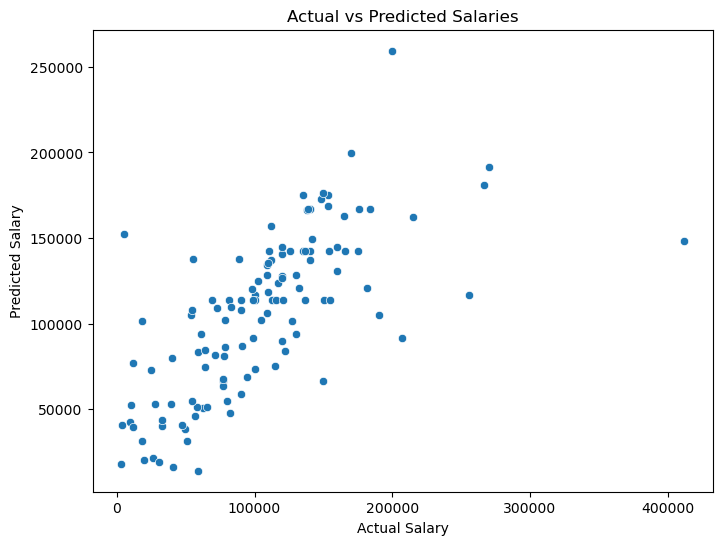

In [20]:
import pandas as pd
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import joblib
import numpy as np

# Load dataset
df = pd.read_csv("ds_salaries.csv")
df.drop(columns=['Unnamed: 0', 'salary', 'salary_currency'], inplace=True)

# Encode categorical variables
le_dict = {}
categorical_cols = df.select_dtypes(include='object').columns
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    le_dict[col] = le

# Features and Target
X = df.drop(columns=['salary_in_usd'])
y = df['salary_in_usd']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train XGBoost Model
model = XGBRegressor()
model.fit(X_train, y_train)

# Evaluate Model
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Save model and encoders
joblib.dump(model, "salary_model.pkl")
joblib.dump(le_dict, "label_encoders.pkl")


# Print metrics
print("\n📊 Model Performance Metrics:")
print(f"🔹 R² Score       : {r2:.4f}")
print(f"🔹 MAE (USD)      : {mae:.2f}")
print(f"🔹 RMSE (USD)     : {rmse:.2f}")
print("✅ All files saved.")
# Optional: Plot predictions
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel("Actual Salary")
plt.ylabel("Predicted Salary")
plt.title("Actual vs Predicted Salaries")
plt.show()

In [22]:
%%writefile app.py
import streamlit as st
import pandas as pd
import joblib

# Load model and encoders
model = joblib.load("salary_model.pkl")
le_dict = joblib.load("label_encoders.pkl")

# Mappings for full forms
experience_mapping = {
    "EN": "Entry-level",
    "MI": "Mid-level",
    "SE": "Senior-level",
    "EX": "Executive-level"
}
employment_mapping = {
    "FT": "Full-time",
    "PT": "Part-time",
    "CT": "Contract",
    "FL": "Freelance"
}
size_mapping = {
    "S": "Small",
    "M": "Medium",
    "L": "Large"
}

# Inverse mappings
exp_inv = {v: k for k, v in experience_mapping.items()}
emp_inv = {v: k for k, v in employment_mapping.items()}
size_inv = {v: k for k, v in size_mapping.items()}

# Streamlit Page Config
st.set_page_config(page_title="Employee Salary Predictor", page_icon="💼")

st.markdown("""
    <div style="text-align:center">
        <h1 style="color:#2E8B57;">💼 Employee Salary Predictor</h1>
        <p style="font-size:17px;">Estimate salary (in USD) based on job profile and work details</p>
    </div>
""", unsafe_allow_html=True)

# Input Form
st.markdown("### 🔧 Enter Employee Details")
col1, col2 = st.columns(2)

with col1:
    work_year = st.selectbox("📅 Work Year", [2020, 2021, 2022, 2023, 2024])
    experience = st.selectbox("🧠 Experience Level", list(experience_mapping.values()))
    employment = st.selectbox("💼 Employment Type", list(employment_mapping.values()))
    job_title = st.selectbox("👔 Job Title", le_dict['job_title'].classes_)

with col2:
    remote_ratio = st.slider("🌐 Remote Work Ratio (%)", 0, 100, 100)
    company_size = st.selectbox("🏢 Company Size", list(size_mapping.values()))
    company_location = st.selectbox("📍 Company Location", le_dict['company_location'].classes_)
    employee_residence = st.selectbox("🏠 Employee Residence", le_dict['employee_residence'].classes_)

# Prepare model input
input_dict = {
    "work_year": work_year,
    "experience_level": le_dict['experience_level'].transform([exp_inv[experience]])[0],
    "employment_type": le_dict['employment_type'].transform([emp_inv[employment]])[0],
    "job_title": le_dict['job_title'].transform([job_title])[0],
    "employee_residence": le_dict['employee_residence'].transform([employee_residence])[0],
    "remote_ratio": remote_ratio,
    "company_location": le_dict['company_location'].transform([company_location])[0],
    "company_size": le_dict['company_size'].transform([size_inv[company_size]])[0],
}

input_df = pd.DataFrame([input_dict])

# Live Preview
st.markdown("---")
st.markdown("### 👁️ Preview Your Selection")
preview_data = {
    "Work Year": work_year,
    "Experience": experience,
    "Employment": employment,
    "Job Title": job_title,
    "Remote %": f"{remote_ratio}%",
    "Company Size": company_size,
    "Company Location": company_location,
    "Residence": employee_residence
}
st.table(pd.DataFrame([preview_data]))

# Prediction
if st.button("🎯 Predict Salary"):
    predicted = model.predict(input_df)[0]
    st.success(f"💰 Predicted Salary: **${round(predicted, 2):,.2f} USD**")
    st.balloons()


Overwriting app.py
